<a href="https://colab.research.google.com/github/nsubbaian/BayesianML/blob/master/Project4/BayesMLProject4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.stats import multivariate_normal

# Helpful Resources:
# https://www.youtube.com/watch?v=XfyR_49hfi8

# Part 1

Re-do part 2 (i.e. plotting predictions) of your linear regression assignment using the Gaussian Process method from section 6.4. 


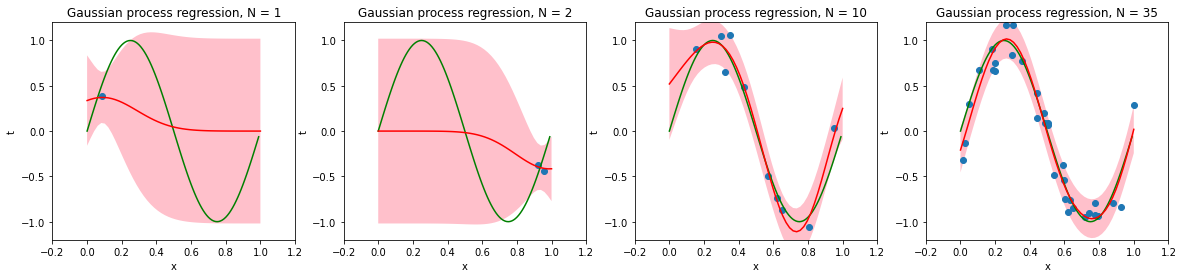

In [2]:
dataSetCount = [1, 2, 10, 35]
beta = 25
fig = plt.figure(figsize=[20,4])

def axisSetup(ax):
    ax.set_xlim(-.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    x = np.arange(0,1, .01) 
    y = np.sin(2 * np.pi *x)
    ax.plot(x,y, color='green')

def kernel(x_i, x_j):
    return np.exp((-(np.absolute(x_i-x_j))**2)/(2*.04))

for i in range(4):
  N = dataSetCount[i]
  axs = plt.subplot(1, 4, i+1)
  axisSetup(axs)

  # Obtain dataset with N values
  x = np.atleast_2d(np.random.uniform(0, 1, N))
  t = np.sin(2 * np.pi *x) + np.random.normal(0, .2, N)    
  C = np.zeros((N, N))
  x_val = np.linspace(0, 1)

  # EQ 6.62
  for i in range(N):
      for j in range(N): C[i, j] = kernel(x[0,i], x[0,j]) + (beta**-1)*(i==j)

  # EQ 6.66 
  k = kernel(x.T, x_val)
  kT_Cn1 = np.matmul(k.T,np.linalg.inv(C))
  M = (np.matmul(kT_Cn1,t.T)).squeeze()

  # EQ 6.67
  c = (kernel(x_val, x_val)+ beta**-1)
  SIG = c - np.diag((np.matmul(kT_Cn1, k)))

  axs.fill_between(x_val, M - np.sqrt(SIG.T), M + np.sqrt(SIG.T), facecolor='pink') 
  axs.plot(x_val, M, color='red')  # red line shows the mean of the Gaussian process predictive distribution
  axs.set_title('Gaussian process regression, N = {}'.format(N))
  plt.scatter(x, t)

plt.show()

# Part 2

Re-do your linear classification assignment using a Support Vector Machine. Do this for the circles dataset, and whatever other dataset you chose from UCI or whathaveyou. Implement the grid search method outlined in this papers: https://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf, plot an ROC and report your % correct. Compare this to your results from the linear classification project.

In [3]:
import scipy.io
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn import svm
import pandas as pd
from sklearn.svm import SVC 

In [4]:
# --------------------------------------------- GET DATA --------------------------------------------
%%capture
!wget https://github.com/nsubbaian/BayesianML/blob/master/Project3/mlData.mat?raw=true
!mv mlData.mat\?raw\=true mlData.mat
matdata = scipy.io.loadmat('mlData.mat')

# Circles Data
circles_xy = matdata['circles'][0][0][0]
colors = ['red','green']
xc, yc = map(list,zip(*circles_xy))
lc = matdata['circles'][0][0][1]

# Wine Data
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', sep = ',',
                 names = ['Alcohol', 'Malic', 'Ash', 'Alcalinity', 'Magnesium', 'phenols', 'Flavanoids',
                          'Nonflavanoid ', 'Proanthocyanins','Color', 'Hue', ' OD280', 'Proline'])
df = df.reset_index()
df = df[df['index'] < 3]
df['index'] = df['index']-1

{'C': 0.0625, 'gamma': 4.0, 'kernel': 'rbf'}
Circles accuracy: 100.0


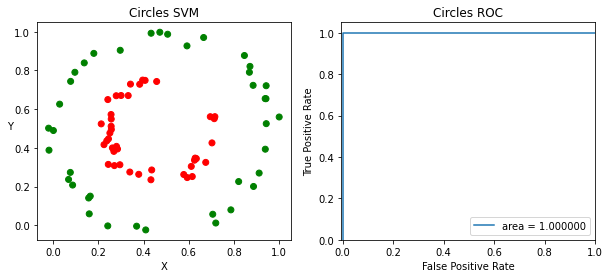

{'C': 4.0, 'gamma': 4.0, 'kernel': 'rbf'}
Wine accuracy: 92.3076923076923


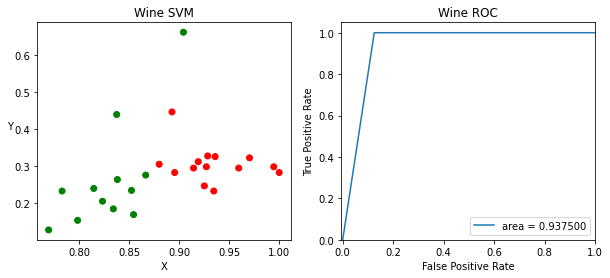

In [5]:
def SVM(coordinates, label, title):

  # Proposed procedure from the paper
  # 1- Transform data to the format of an SVM package
  # 2 - simple scaling of the data, making sure to scale the train and test with the same scaling factors
  x_train, x_test, t_train, t_test = train_test_split(coordinates/coordinates.max(axis=0), label.squeeze(), test_size=0.20) 

  # 3 - Consider the rbf kernel
  #  try exponentially growing sequences of C and γ
  Kernel_vals = ['rbf', 'linear']

  # Loose grid search was performed, then changed to a fine grid search
  C_vals= np.power(2, np.linspace(-5,15, 21))
  Gamma_vals= np.power(2, np.linspace(-15,3, 19))

  # 4 - Use cross-validation to find the best parameter C and γ
  parameters = {'kernel': Kernel_vals, 'C':C_vals, 'gamma': Gamma_vals}
  grid = GridSearchCV(estimator=SVC(), param_grid=parameters) # the default is 5-fold

  # 5 - Use the best parameter C and γ to train the whole training set
  grid.fit(x_train, t_train)
  print(grid.best_params_)

  # 6 - Test
  t = grid.predict(x_test)
  print(title, "accuracy:", np.sum(t == t_test)/len(t_test) *100)

  fig, ax = plt.subplots(1, 2, figsize=(10, 4))
  xc, yc = map(list,zip(*x_test[:,:2]))
  ax[0].scatter(xc, yc, c=t, cmap=matplotlib.colors.ListedColormap(colors))
  ax[0].set_title(title + ' SVM')
  ax[0].set_xlabel('X')
  ax[0].set_ylabel('Y', rotation=0)

  fpr, tpr, _ = metrics.roc_curve(t_test,t)
  auc = metrics.auc(fpr, tpr)
  ax[1].set_title(title + ' ROC')
  ax[1].plot(fpr, tpr, label = 'area = %f' %auc)
  ax[1].legend(loc = 'lower right')
  ax[1].set_xlim([-0.005, 1])
  ax[1].set_ylim([0, 1.05])
  ax[1].set_ylabel('True Positive Rate')
  ax[1].set_xlabel('False Positive Rate')

  plt.show()

# Circles Data
SVM(circles_xy, lc, "Circles")

# Wine Data
SVM(np.asarray(df[['Alcohol','Malic','Magnesium', 'phenols']]), df['index'].values, "Wine")

Overall the results in accuracy was pretty comparable to the prior method used(probably due to the small dataset size). However this process was much easier to understand/code.